In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression

In [2]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"

In [446]:
### Load Data ###
'''
'x': x coordinate in UMAP space
'y': y coordinate in UMAP space
'xnew': x coordinate associated with nearest bin on 64x64 grid
'ynew': y coordinate associated with nearest bin on 64x64 grid
'xy_new': unique identifier resulting from combo of xnew and ynew
'coords': unique identifier resulting from converting xy_new to numeric representation (via rastering)
'time'
'individual' 
'''

umap_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201031_UMAP/'
umap_file = os.path.join(umap_dir, 'luke_fictrac_TREBLE_layout_win14_102520.txt')
#umap_raw = np.genfromtxt(umap_file, usecols=(0,1,-2,-1), dtype=str,skip_header=1)
umap_raw = np.genfromtxt(umap_file, dtype=str,skip_header=1)

umap_fly_names = ['fictrac-20200228_161226_fly87', 'fictrac-20200618_081653_fly89',
       'fictrac-20200620_122048_fly94',
       'fictrac-20200627_113329_fly97', 'fictrac-20200627_130208_fly98',
       'fictrac-20200627_142647_fly99', 'fictrac-20200702_083849_fly100',
       'fictrac-20200702_100612_fly101', 'fictrac-20200704_142706_fly105']

# Calculate course scale bins
out = scipy.stats.binned_statistic_2d(umap_raw[:,0].astype(float),
                                      umap_raw[:,1].astype(float), 
                                      umap_raw[:,1].astype(float),
                                      bins=8)

umap_raw = np.concatenate((out[3][:,np.newaxis], umap_raw),axis=-1)

umap = {}
for i,fly in enumerate(umap_fly_names):
    fly_idx = np.where(umap_raw[:,-1]==fly)[0]
    umap[fly_names[i]] = umap_raw[fly_idx,:-1]#.astype(float)

In [43]:
z=20
brain_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/superslice_{}.nii".format(z) #<---------- !!!
brain = np.array(nib.load(brain_file).get_data(), copy=True)
fly_idx_delete = 3 #(fly_095)
brain = np.delete(brain, fly_idx_delete, axis=-1) #### DELETING FLY_095 ####

In [44]:
#load clusters
n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/final_9_cluster_labels_2000.npy'
cluster_model_labels = np.load(labels_file) #z,t

In [45]:
### How to organize this code? How to implement?
# Best to loop over z-slices?
# Or umap points?
# For each unique 64 grid point there is a list of times and flies

# Lets loop over each fly, and each z-slice, and put each into the correct 64x64bin based on
# closest timing



#load umap
#for fly in fly_names:
fly = 'fly_087'
#load timestamps
timestamps = bbb.load_timestamps(os.path.join(dataset_path, fly, 'func_0', 'imaging'))
#load z-correction
to_load = os.path.join(dataset_path, fly, 'warp', '20201220_warped_z_depth.nii')
z_correction = np.array(nib.load(to_load).get_data(), copy=True)


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 65.91 ms


In [348]:
umap['fly_087'][:,0]

array(['226', '209', '192', ..., '51', '51', '51'], dtype='<U30')

In [50]:
idx = np.searchsorted(umap['fly_087'][:,-1].astype(float)*1000, timestamps)-1
bin_ids = umap['fly_087'][idx,0]

#create neural features (get cluster averages)
z_map = z_correction[:,:,z].ravel() #for correcting z-depth
neural_data = brain[:,:,:,0].reshape(-1, 3384)

signals = []
cluster_bins = []

for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels[z,:]==cluster_num)[0]
    mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
    signals.append(mean_signal)
    original_z = int(np.median(z_map[cluster_indicies]))
    cluster_bins.append(bin_ids[:,original_z])

signals = np.asarray(signals)
cluster_bins = np.asarray(cluster_bins)

In [71]:
signals.shape, cluster_bins.shape

((2000, 3384), (2000, 3384))

In [110]:
unique_bins = np.unique(umap_raw[:,0].astype(int))

binned=np.empty((n_clusters,len(unique_bins)),object)
for i in range(n_clusters):
    for j in range(len(unique_bins)):
        binned[i,j] = []

for i,unique_bin in enumerate(unique_bins):
    for cluster in range(n_clusters):
        idx = list(np.where(cluster_bins[cluster,:]==unique_bin)[0])
        binned[cluster,i].extend(list(signals[cluster,idx]))

In [112]:
binned.shape

(2000, 177)

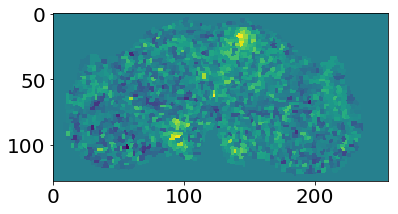

In [287]:
bin_id = np.where(unique_bins==55)[0][0]

colored_by_betas = np.zeros((256*128))
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels[z,:]==cluster_num)[0]
    colored_by_betas[cluster_indicies] = np.mean(binned[cluster_num,bin_id])
colored_by_betas = colored_by_betas.reshape(256,128)

plt.imshow(colored_by_betas.T)

In [449]:
# next step?
# I would like to know where these binids land in umap space

xs = []
ys = []

bin_vector = umap_raw[:,0].astype(int)
x_vector = umap_raw[:,1].astype(float)
y_vector = umap_raw[:,2].astype(float)

for unique_bin in unique_bins:
    idx = np.where(bin_vector==unique_bin)
    xs.append(np.mean(x_vector[idx]))
    ys.append(np.mean(y_vector[idx]))

In [357]:
samples = []
for bin_id in range(len(unique_bins)):
    samples_=0
    for cluster in range(n_clusters):
        samples_+=len(binned[cluster,bin_id])
    samples.append(samples_/1000)

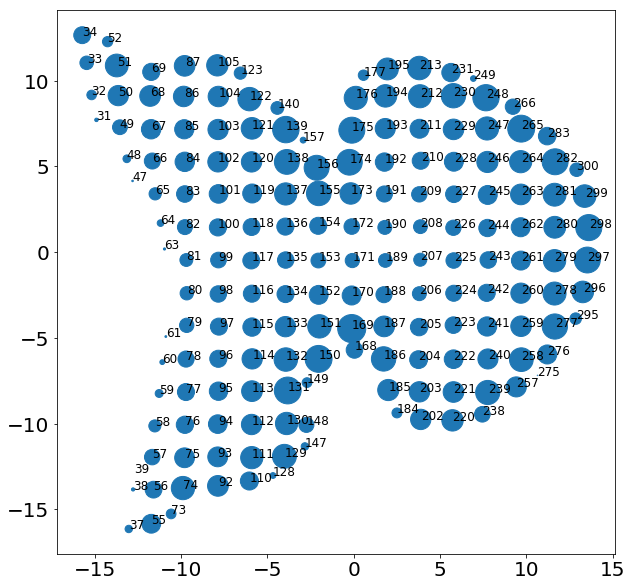

In [358]:
plt.figure(figsize=(10,10))
plt.scatter(xs,ys,s=samples)
for i in range(len(unique_bins)):
    plt.text(s=unique_bins[i],x=xs[i],y=ys[i],fontsize=12)

In [458]:
### ALL FLIES ###
unique_bins = np.unique(umap_raw[:,0].astype(int))
binned=np.empty((n_clusters,len(unique_bins)),object)
for i in range(n_clusters):
    for j in range(len(unique_bins)):
        binned[i,j] = []

for fly_num,fly in enumerate(fly_names[:1]):
    print(fly)
    #load timestamps
    timestamps = bbb.load_timestamps(os.path.join(dataset_path, fly, 'func_0', 'imaging'))
    #load z-correction
    to_load = os.path.join(dataset_path, fly, 'warp', '20201220_warped_z_depth.nii')
    z_correction = np.array(nib.load(to_load).get_data(), copy=True)

    idx = np.searchsorted(umap[fly][:,-1].astype(float)*1000, timestamps)-1
    bin_ids = umap[fly][idx,0].astype(int)

    #create neural features (get cluster averages)
    z_map = z_correction[:,:,z].ravel() #for correcting z-depth
    neural_data = brain[:,:,:,fly_num].reshape(-1, 3384)

    signals = []
    cluster_bins = []

    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(cluster_model_labels[z,:]==cluster_num)[0]
        mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
        signals.append(mean_signal)
        original_z = int(np.median(z_map[cluster_indicies]))
        cluster_bins.append(bin_ids[:,original_z])

    signals = np.asarray(signals)
    cluster_bins = np.asarray(cluster_bins)
    
    for i,unique_bin in enumerate(unique_bins):
        for cluster in range(n_clusters):
            idx = list(np.where(cluster_bins[cluster,:]==unique_bin)[0])
            binned[cluster,i].extend(list(signals[cluster,idx]))

fly_087

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 3.89 ms


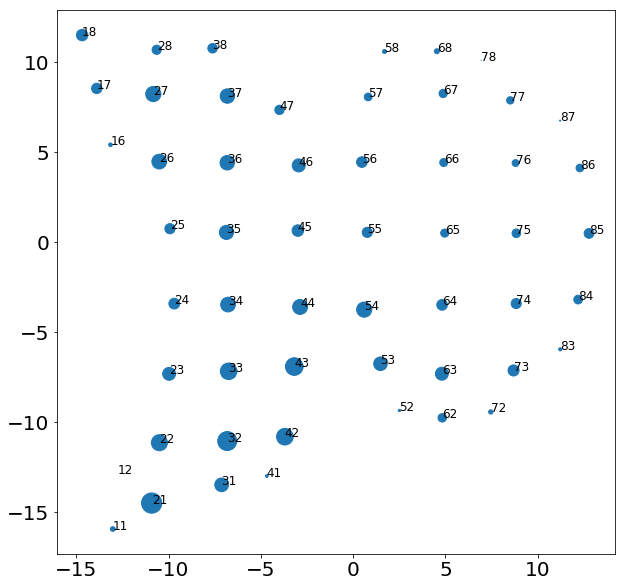

In [459]:
# next step?
# I would like to know where these binids land in umap space

xs = []
ys = []

bin_vector = umap_raw[:,0].astype(int)
x_vector = umap_raw[:,1].astype(float)
y_vector = umap_raw[:,2].astype(float)

for unique_bin in unique_bins:
    idx = np.where(bin_vector==unique_bin)
    xs.append(np.mean(x_vector[idx]))
    ys.append(np.mean(y_vector[idx]))

samples = []
for bin_id in range(len(unique_bins)):
    samples_=0
    for cluster in range(n_clusters):
        samples_+=len(binned[cluster,bin_id])
    samples.append(samples_/1000)
    
plt.figure(figsize=(10,10))
plt.scatter(xs,ys,s=samples)
for i in range(len(unique_bins)):
    plt.text(s=unique_bins[i],x=xs[i],y=ys[i],fontsize=12)
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

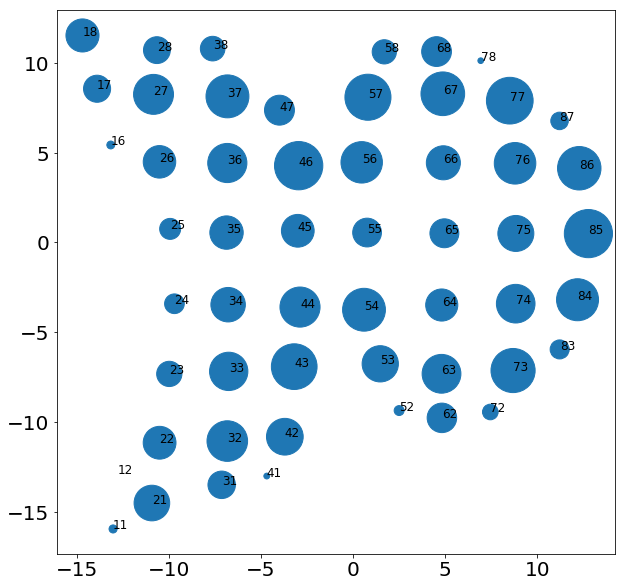

In [454]:
# next step?
# I would like to know where these binids land in umap space

xs = []
ys = []

bin_vector = umap_raw[:,0].astype(int)
x_vector = umap_raw[:,1].astype(float)
y_vector = umap_raw[:,2].astype(float)

for unique_bin in unique_bins:
    idx = np.where(bin_vector==unique_bin)
    xs.append(np.mean(x_vector[idx]))
    ys.append(np.mean(y_vector[idx]))

samples = []
for bin_id in range(len(unique_bins)):
    samples_=0
    for cluster in range(n_clusters):
        samples_+=len(binned[cluster,bin_id])
    samples.append(samples_/1000)
    
plt.figure(figsize=(10,10))
plt.scatter(xs,ys,s=samples)
for i in range(len(unique_bins)):
    plt.text(s=unique_bins[i],x=xs[i],y=ys[i],fontsize=12)
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [452]:
samples

177

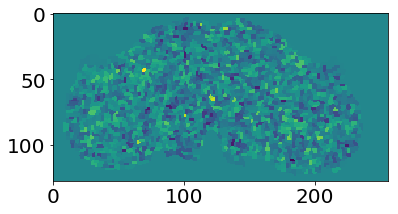

In [425]:
bin_id = np.where(unique_bins==206)[0][0]

colored_by_betas = np.zeros((256*128))
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels[z,:]==cluster_num)[0]
    colored_by_betas[cluster_indicies] = np.mean(binned[cluster_num,bin_id])
colored_by_betas = colored_by_betas.reshape(256,128)

plt.imshow(colored_by_betas.T)

In [431]:
unique_bins

array([ 31,  32,  33,  34,  37,  38,  39,  47,  48,  49,  50,  51,  52,
        55,  56,  57,  58,  59,  60,  61,  63,  64,  65,  66,  67,  68,
        69,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 202,
       203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 238, 239, 240,
       241, 242, 243, 244, 245, 246, 247, 248, 249, 257, 258, 259, 260,
       261, 262, 263, 264, 265, 266, 275, 276, 277, 278, 279, 280, 281,
       282, 283, 295, 296, 297, 298, 299, 300])

In [455]:
len(unique_bins)

54

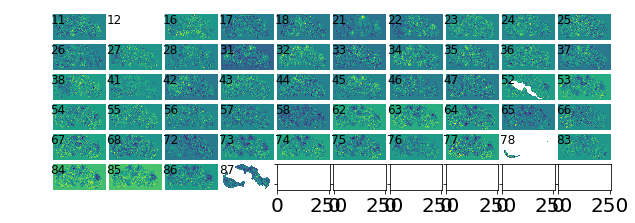

In [460]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 10), axes_pad=.05)
for i,bin_id_ in enumerate(unique_bins):
    bin_id = np.where(unique_bins==bin_id_)[0][0]

    colored_by_betas = np.zeros((256*128))
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(cluster_model_labels[z,:]==cluster_num)[0]
        colored_by_betas[cluster_indicies] = np.mean(binned[cluster_num,bin_id])
    colored_by_betas = colored_by_betas.reshape(256,128)
    
    grid[i].imshow(colored_by_betas.T)
    grid[i].axis('off')
    grid[i].set_title(bin_id_,fontsize=12,x=.1,y=.4)
#plt.subplots_adjust(hspace=50)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

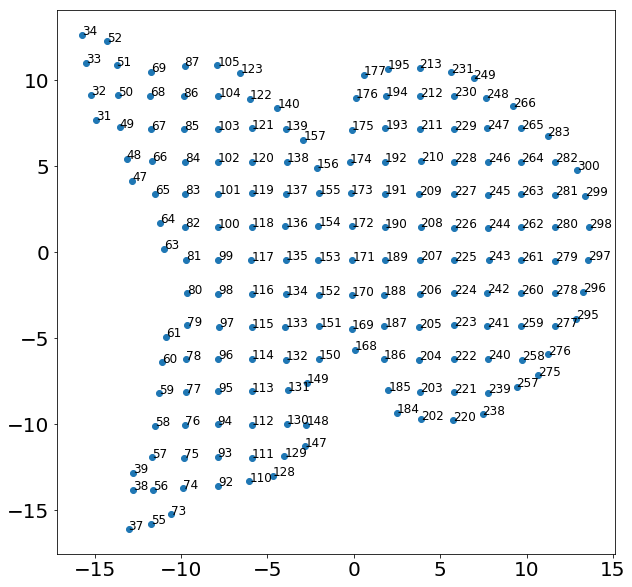

In [334]:
plt.figure(figsize=(10,10))

plt.plot(xs,ys,'o')

for i in range(len(unique_bins)):
    plt.text(s=unique_bins[i],x=xs[i],y=ys[i],fontsize=12)

In [ ]:
for i,unique_bin in enumerate(unique_bins):
    

In [228]:
out[1]

array([-16.64114825, -14.69310401, -12.74505977, -10.79701552,
        -8.84897128,  -6.90092703,  -4.95288279,  -3.00483854,
        -1.0567943 ,   0.89124994,   2.83929419,   4.78733843,
         6.73538268,   8.68342692,  10.63147116,  12.57951541,
        14.52755965])

In [234]:
out[2]

array([-16.69296235, -14.78572722, -12.87849208, -10.97125695,
        -9.06402181,  -7.15678668,  -5.24955155,  -3.34231641,
        -1.43508128,   0.47215386,   2.37938899,   4.28662412,
         6.19385926,   8.10109439,  10.00832952,  11.91556466,
        13.82279979])

In [236]:
np.max(out[3])

300

31

In [238]:
umap_raw.shape

(899860, 9)

In [243]:
xs = []
ys = []
for unique_bin in unique_bins:
    idx = np.where(umap_raw[:,0].astype(int)==unique_bin)
    xs.append(np.mean(umap_raw[idx,1].astype(float)))
    ys.append(np.mean(umap_raw[idx,2].astype(float)))

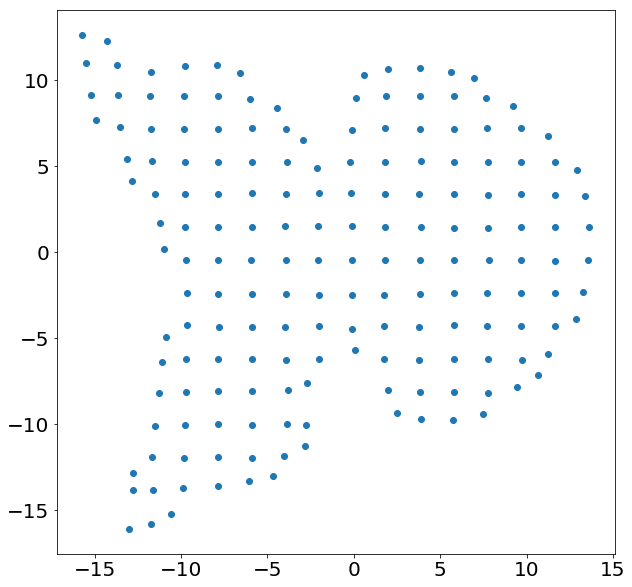

In [239]:
umap_raw[:,0]

array(['226', '209', '192', ..., '245', '247', '230'], dtype='<U30')

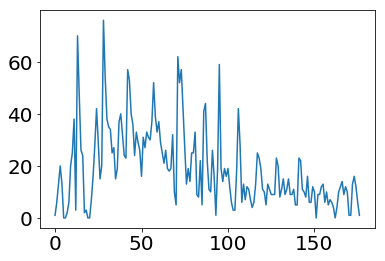

In [116]:
w=[]
for i in range(177):
    w.append(len(binned[1000,i]))
plt.plot(w)

In [117]:
np.max(w)

76

In [38]:
# all_signals = []
# all_times = []
# for z in range(49):
#     print(z)
#     #z=20
#     #create neural features (get cluster averages)
#     z_map = z_correction[:,:,z].ravel() #for correcting z-depth
#     neural_data = brain[:,:,z,:].reshape(-1, 3384)
#     signals = []
#     times = []
#     for cluster_num in range(n_clusters):
#         cluster_indicies = np.where(cluster_model_labels[z,:]==cluster_num)[0]
#         mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
#         signals.append(mean_signal)
#         original_z = int(np.median(z_map[cluster_indicies]))
#         times.append(timestamps[:,original_z])
#     signals = np.asarray(signals)
#     times = np.asarray(times)
#     all_signals.append(signals)
#     all_times.append(times)
# all_signals = np.asarray(all_signals)
# all_times = np.asarray(all_times)
    #timestamps[:,original_zs]




#get this fly's umap


# let say we create a 49,2000,3384 for signals and times
# then i have to step through each time element, find it's nearest umap,
# and assign the signal to the correct 49,2000 bin

# will be placing things into an array of 64,64,49,2000,i
# where i is the number of signals in that bin for that supervoxel



# ok so actually all fly's timestamps are the same
# it would be most efficient to convert the timestamp array
# from the 3384,49 timestamps, make a new 3384,49 array of umap bins

# lets say we make the 3384,49 of umap bins
# then, for each cluster within a given z, I can do umap_bins[:,original_z]
# to get a vector of bins for that cluster
# I will end up with an array of 49,2000,3384 for all cluster's bin_id at each timepoint
# finally, for each bin_id, for each cluster, collect the values
# ie, will end up with a list of arrays. or array of lists?
# final is 64,64,49,2000, with final map as 64,64,49,128,256


idx = np.searchsorted(umap['fly_087'][:,-1].astype(float)*1000, timestamps)-1
bin_ids = umap['fly_087'][idx,0] #-2 for unique raster, -3 for unique xy

all_signals = []
all_cluster_bins = []

for z in range(49):
    print(z)
    #z=20
    #create neural features (get cluster averages)
    z_map = z_correction[:,:,z].ravel() #for correcting z-depth
    neural_data = brain[:,:,z,:].reshape(-1, 3384)
    
    signals = []
    cluster_bins = []
    
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(cluster_model_labels[z,:]==cluster_num)[0]
        mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
        signals.append(mean_signal)
        original_z = int(np.median(z_map[cluster_indicies]))
        cluster_bins.append(bin_ids[:,original_z])
    
    all_signals.append(np.asarray(signals))
    all_cluster_bins.append(np.asarray(cluster_bins))
    
all_signals = np.asarray(all_signals)
all_cluster_bins = np.asarray(all_cluster_bins)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


In [39]:
all_signals.shape, all_cluster_bins.shape

((49, 2000, 3384), (49, 2000, 3384))

In [121]:
# I will end up with an array of 49,2000,3384 for all cluster's bin_id at each timepoint
# finally, for each bin_id, for each cluster, collect the values
# ie, will end up with a list of arrays. or array of lists?
# final is 64,64,49,2000, with final map as 64,64,49,128,256

# more accurately, each unique bin should be an array of 49,2000

# d=np.empty((2000,),object)
# d[...]=[[] for _ in range(2000)]
# d=np.array([d,]*49)
# binned_clusters=np.array([d,]*2435)

unique_bins = np.unique(umap_raw[:,-3].astype('int')) #2435

for unique_bin in unique_bins:
    print(unique_bin)
    for z in range(49):
        for cluster in range(n_clusters):
            idx = np.where(all_cluster_bins[z,cluster,:]==unique_bin)[0]
            binned_clusters[unique_bin,z,cluster].extend(all_signals[z,cluster,idx])

1
2
3
4
5
6
7


KeyboardInterrupt: 

In [131]:
binned_clusters[100,40,0]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.11245427,
 -0.22949639,
 -0.18644442,
 0.007290111,
 -0.0039536054,
 -0.0037618252,
 2.0408654,
 -0.37002972,
 -0.005872339,
 -0.5614703,
 -0.8480614,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.34917745,
 1.0482917,
 -0.3654402,
 -0.23164076,
 0.5301229,
 -0.21693633,
 0.7711391,
 -0.4544602,
 -0.8997558,
 -0.11173748,
 0.35240293,
 0.5083714,
 0.3779508,
 -0.36624867,
 1.1385095,
 -0.056109086,
 0.09064691,
 1.1075361,
 -0.70951337,
 -0.5228394,
 -0.25160486,
 0.17793423,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.24028875,
 -0.1068524,
 -0.2873555,
 -0.0037302068,
 -0.0023100057,
 -0.16850735,
 -0.062941656,
 0.5559026,
 0.32318503,
 0.7405937,
 -0.56223047,
 -0.32255164,
 -0.11238227,
 1.019379,
 0.5969843,
 1.5119362,
 0.4996023,
 -0.31015357,
 1.7505178,
 -0.87148184,
 -0.031817958,
 1.1370566,
 -0.3826471,
 0.32530883,
 -0.100569

In [114]:
np.where(all_cluster_bins[20,1000,:]==unique_bin)[0]

array([2261])

In [119]:
#a=[]
a.append(np.array([2261,1000]))

In [151]:
d=np.empty((10,10,10),object)
d[:,]=[[] for _ in range(10)]

ValueError: could not broadcast input array from shape (10,0) into shape (10,10,10)

In [132]:
d=np.empty((10,10,),object)
d[...]=[[] for _ in range(100)]
d=np.array([d,]*49)
binned_clusters=np.array([d,]*2435)

In [136]:
2000*49*2435

238630000

In [142]:
binned_clusters = [[] for i in range(2000*49*2435)]

In [145]:
a = [[] for i in range(100)]

In [147]:
np.reshape(a,(10,10))

ValueError: cannot reshape array of size 0 into shape (10,10)

In [144]:
binned_clusters

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],


[[], [], [1], [], [], [], [], [], [], []]

In [134]:
binned_clusters[0,0,0].append(1)

In [97]:
binned_clusters[0,0,0]

[]

In [ ]:
#or is it just going to be nested lists?

In [43]:
np.zeros((2,2))

array([[0., 0.],
       [0., 0.]])

In [ ]:
binned_clusters[z,cluster,unique_bin].append()

In [86]:
len(np.unique(umap_raw[:,-3].astype('int')))

2435

In [89]:
d.shape

(2435, 49, 2000)

In [73]:
d

array([list([]), list([]), list([]), ..., list([]), list([]), list([])],
      dtype=object)

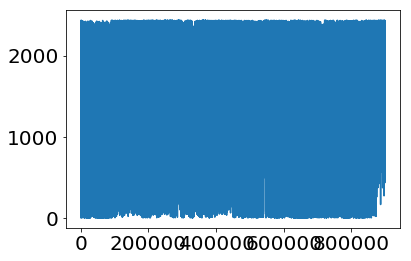

In [32]:
plt.plot(umap_raw[:,-3].astype('float'))

2435

In [19]:
np.shape(np.where(all_cluster_bins==1.000e+00))

(3, 66258)

In [21]:
64*64

4096

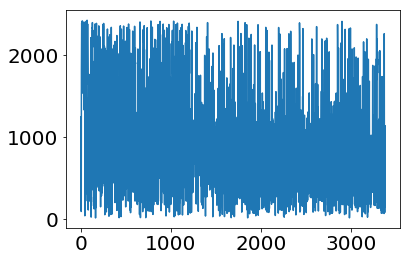

In [9]:
plt.plot(all_cluster_bins[20,0,:])

In [35]:
umap['fly_087'].shape

(89986, 7)

In [42]:
umap['fly_087'][:,-1]*1000

array([0.00000e+00, 2.00000e+01, 4.00000e+01, ..., 1.79966e+06,
       1.79968e+06, 1.79970e+06])

In [41]:
timestamps[:,20]

array([2.79079712e+02, 8.11075413e+02, 1.34307111e+03, ...,
       1.79895654e+06, 1.79948854e+06, 1.80002054e+06])

In [83]:
idx = np.searchsorted(umap['fly_087'][:,-1].astype(float)*1000, timestamps)-1

In [94]:
#bin_ids = umap['fly_087'][idx,-3]
bin_ids = umap['fly_087'][idx,-2].astype('float')

In [91]:
np.shape(bin_ids)

(3384, 49)

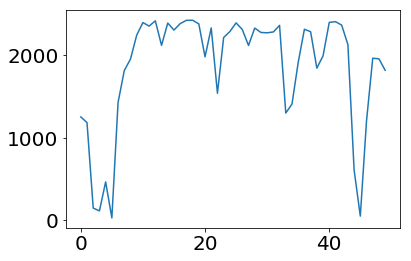

In [97]:
plt.plot(bin_ids[:50,20])

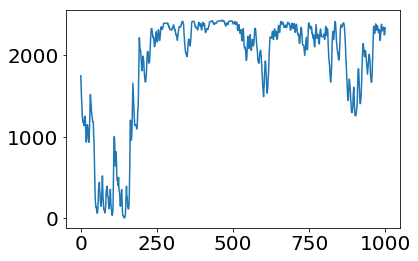

In [50]:
plt.plot(umap['fly_087'][:1000,-2])

In [52]:
len(np.unique(umap['fly_087'][:,-2]))

2412

In [53]:
64*64

4096

In [ ]:
for z in range(49):
    

In [23]:
49*2000*3384

331632000

In [22]:
all_signals.shape, all_times.shape

((49, 2000, 3384), (49, 2000, 3384))

In [19]:
timestamps[:,20]

array([2.79079712e+02, 8.11075413e+02, 1.34307111e+03, ...,
       1.79895654e+06, 1.79948854e+06, 1.80002054e+06])

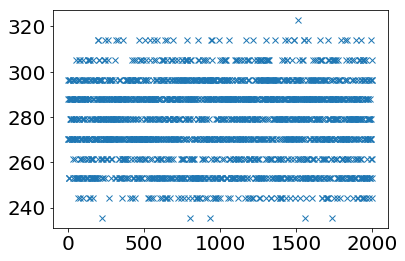

In [14]:
plt.plot(times[:,0],'x')

In [9]:
times.shape

(2000, 3384)

In [16]:
times[:,1000]

array([532283.501953, 532266.059471, 532292.223194, ..., 532292.223194,
       532248.616989, 532300.944435])

In [10]:
signals.shape

(2000, 3384)

In [4]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
fly='fly_087'
brain_file = os.path.join(dataset_path, fly, 'func_0', 'brain_zscored_green_high_pass_masked_warped.nii')
brain = np.array(nib.load(brain_file).get_data(), copy=True)
brain.shape

(256, 128, 49, 3384)

In [77]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self, z):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Velocity ###
            low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
            self.fictrac[short] = low_res_behavior#/np.std(low_res_behavior)

            ### Clipped Velocities ###
            self.fictrac[short + '_pos'] = np.clip(self.fictrac[short], a_min=0, a_max=None)
            self.fictrac[short + '_neg'] = np.clip(self.fictrac[short], a_min=None, a_max=0)*-1

            ### Strongly Clipped Velocities ###
            # excludes points even close to 0
            #self.fictrac[short + '_pos_very'] = np.clip(self.fictrac[short], a_min=0.3, a_max=None)
            #self.fictrac[short + '_neg_very'] = np.clip(self.fictrac[short], a_min=None, a_max=-0.3)*-1

            ### Acceleration ###
            high_res_behavior = self.pull_from_interp_object(interp_object, high_res_timepoints)
            self.fictrac[short + 'h'] = high_res_behavior/np.std(high_res_behavior)

            accel = scipy.signal.savgol_filter(np.diff(high_res_behavior),25,3)
            accel = np.append(accel, 0)
            interp_object = interp1d(high_res_timepoints, accel, bounds_error = False)
            acl = interp_object(self.timestamps[:,z])
            acl[-1] = 0
            self.fictrac[short + 'a'] = acl#/np.std(acl)

            ### Clipped Acceleration ###
            self.fictrac[short + 'a' + '_pos'] = np.clip(self.fictrac[short + 'a'], a_min=0, a_max=None)
            self.fictrac[short + 'a' + '_neg'] = np.clip(self.fictrac[short + 'a'], a_min=None, a_max=0)*-1

        self.fictrac['YZ'] = np.sqrt(np.power(self.fictrac['Y'],2), np.power(self.fictrac['Z'],2))
        self.fictrac['YZh'] = np.sqrt(np.power(self.fictrac['Yh'],2), np.power(self.fictrac['Zh'],2))

In [48]:
z=20
#######################
### Load Superslice ###
#######################
brain_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/superslice_{}.nii".format(z) #<---------- !!!
brain = np.array(nib.load(brain_file).get_data(), copy=True)
fly_idx_delete = 3 #(fly_095)
brain = np.delete(brain, fly_idx_delete, axis=-1) #### DELETING FLY_095 ####

#####################
### Load Clusters ###
#####################
n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/final_9_cluster_labels_2000.npy'
cluster_model_labels = np.load(labels_file) #z,t
cluster_model_labels = cluster_model_labels[z,:]

###################
### Build Flies ###
###################
flies = {}
for i, fly in enumerate(fly_names):
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.interp_fictrac(z)
    flies[fly].load_brain_slice()
    flies[fly].load_z_depth_correction()
    flies[fly].get_cluster_averages(cluster_model_labels, n_clusters)


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 4.86 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.03 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 3.36 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.00 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 3.68 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.05 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 5.90 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.04 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 3.46 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.06 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 3.55 ms

~

In [49]:
flies['fly_087'].timestamps.shape

(3384, 49)

In [ ]:
for fly in fly_names:
    for cluster_num in n_clusters:
        cluster_indicies = flies[fly].cluster_indicies[cluster_num]
        z_map = flies[fly].z_correction[:,:,z].ravel()
        original_z = int(np.median(z_map[cluster_indicies]))
        
        

In [29]:
### Load Data ###
'''
'x': x coordinate in UMAP space
'y': y coordinate in UMAP space
'xnew': x coordinate associated with nearest bin on 64x64 grid
'ynew': y coordinate associated with nearest bin on 64x64 grid
'xy_new': unique identifier resulting from combo of xnew and ynew
'coords': unique identifier resulting from converting xy_new to numeric representation (via rastering)
'time'
'individual' 
'''

umap_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201031_UMAP/'
umap_file = os.path.join(umap_dir, 'luke_fictrac_TREBLE_layout_win14_102520.txt')
#umap_raw = np.genfromtxt(umap_file, usecols=(0,1,-2,-1), dtype=str,skip_header=1)
umap_raw = np.genfromtxt(umap_file, dtype=str,skip_header=1)

umap_fly_names = ['fictrac-20200228_161226_fly87', 'fictrac-20200618_081653_fly89',
       'fictrac-20200620_122048_fly94',
       'fictrac-20200627_113329_fly97', 'fictrac-20200627_130208_fly98',
       'fictrac-20200627_142647_fly99', 'fictrac-20200702_083849_fly100',
       'fictrac-20200702_100612_fly101', 'fictrac-20200704_142706_fly105']

In [30]:
umap = {}
for i,fly in enumerate(umap_fly_names):
    fly_idx = np.where(umap_raw[:,-1]==fly)[0]
    umap[fly_names[i]] = umap_raw[fly_idx,:-1].astype(float)

In [33]:
umap['fly_087'].shape

(89986, 7)

In [126]:
def interp_umap(fly):
    umap_x_all = []
    umap_y_all = []
    for z in range(49):
        ### X-values ###
        interp_object = interp1d(umap[fly][:,-1]*1000, umap[fly][:,0], bounds_error = False)
        umap_x = interp_object(flies[fly].timestamps[:,z])
        np.nan_to_num(umap_x, copy=False);
        umap_x_all.append(umap_x)

        ### Y-values ###
        interp_object = interp1d(umap[fly][:,-1]*1000, umap[fly][:,1], bounds_error = False)
        umap_y = interp_object(flies[fly].timestamps[:,z])
        np.nan_to_num(umap_y, copy=False);
        umap_y_all.append(umap_y)
    
    umap_x_all = np.asarray(umap_x_all)
    umap_y_all = np.asarray(umap_y_all)
    return umap_x_all, umap_y_all

In [141]:
umap_x_all = {}
umap_y_all = {}
for fly in fly_names:
    print(fly)
    umap_x, umap_y = interp_umap(fly)
    umap_x_all[fly] = umap_x
    umap_y_all[fly] = umap_y

#umap_x_all = np.asarray(umap_x_all)
#umap_y_all = np.asarray(umap_y_all)

fly_087
fly_089
fly_094
fly_097
fly_098
fly_099
fly_100
fly_101
fly_105


In [132]:
umap_x_all.shape

(9, 49, 3384)

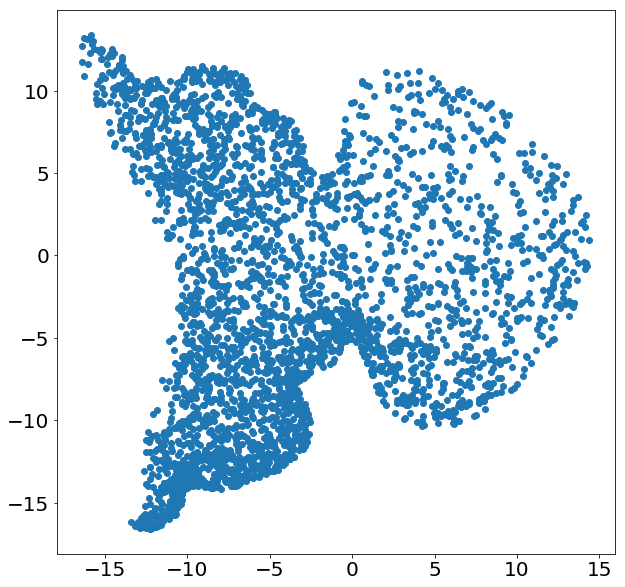

In [173]:
plt.figure(figsize=(10,10))
plt.plot(umap_x_all['fly_087'][20,:], umap_y_all['fly_087'][20,:],'o')

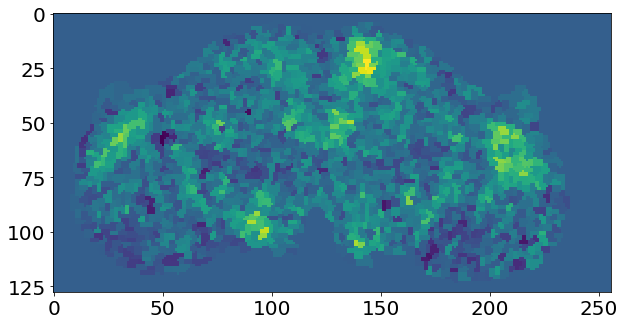

In [227]:
fly = 'fly_087'

x_center = -10
y_center = -10
radius = 

cluster_avgs = []
for cluster_num in range(n_clusters):
    cluster_indicies = flies[fly].cluster_indicies[cluster_num]
    z_map = flies[fly].z_correction[:,:,z].ravel()
    original_z = int(np.median(z_map[cluster_indicies]))
    
    points = np.where((umap_x_all[fly][original_z,:]-x_center)**2 + (umap_y_all[fly][original_z,:]-y_center)**2 < radius**2)[0]
    cluster_avgs.append(np.mean(flies[fly].cluster_signals[cluster_num,points]))
    
colored_by_betas = np.zeros((256*128))
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels[:]==cluster_num)[0]
    colored_by_betas[cluster_indicies] = cluster_avgs[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)

plt.figure(figsize=(10,10))
plt.imshow(colored_by_betas.T)

In [188]:
umap_x_all['fly_087'].shape

(49, 3384)

In [189]:
points

array([  22,   33,   34,   38,   60,   67,   74,   78,   84,   85,   88,
         90,   92,   93,  102,  103,  107,  108,  110,  126,  141,  146,
        150,  153,  154,  157,  167,  171,  183,  194,  197,  198,  201,
        202,  206,  207,  209,  210,  212,  214,  231,  232,  235,  252,
        269,  270,  275,  276,  277,  279,  280,  281,  289,  301,  302,
        303,  319,  329,  330,  331,  335,  336,  353,  354,  356,  357,
        370,  371,  375,  382,  383,  387,  388,  389,  392,  396,  406,
        408,  409,  410,  411,  414,  422,  423,  432,  445,  449,  450,
        452,  453,  458,  459,  464,  474,  475,  479,  484,  487,  488,
        489,  490,  491,  492,  494,  502,  504,  511,  516,  517,  518,
        524,  540,  551,  555,  558,  561,  567,  569,  570,  574,  579,
        581,  587,  588,  594,  595,  605,  615,  625,  626,  640,  643,
        646,  647,  655,  657,  659,  660,  670,  672,  673,  674,  678,
        679,  691,  702,  703,  704,  720,  724,  7

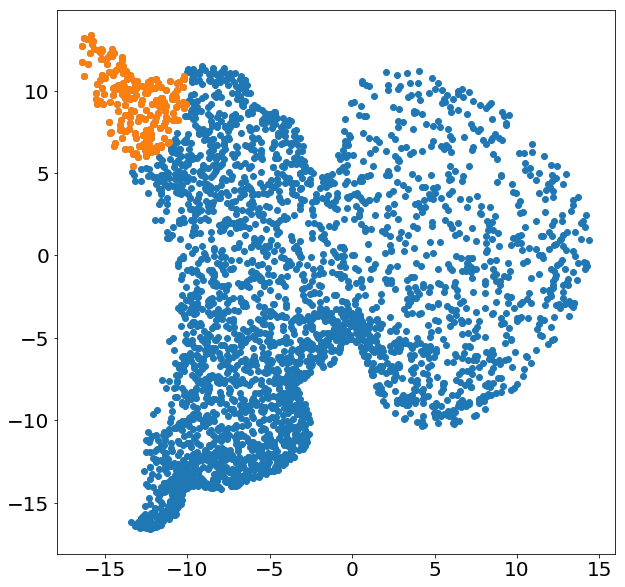

In [213]:
points = np.where((umap_x_all[fly][20,:]-x_center)**2 + (umap_y_all[fly][20,:]-y_center)**2 < radius**2)[0]

plt.figure(figsize=(10,10))
plt.plot(umap_x_all['fly_087'][20,:],umap_y_all['fly_087'][20,:],'o')
plt.plot(umap_x_all['fly_087'][20,points],umap_y_all['fly_087'][20,points],'o')

In [165]:


x_center = -10
np.where((umap_x_all[fly][original_z,:]-x_center)**2 + (umap_x_all[fly][original_z,:]-y_center)**2 < radius**2)[0]


array([], dtype=int64)

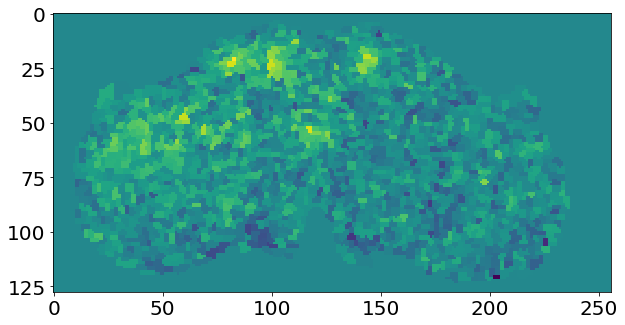

In [179]:
fly = 'fly_087'

x_center = -5
y_center = 0
radius = 5

cluster_avgs = []
for cluster_num in range(n_clusters):
    cluster_indicies = flies[fly].cluster_indicies[cluster_num]
    z_map = flies[fly].z_correction[:,:,z].ravel()
    original_z = int(np.median(z_map[cluster_indicies]))
    
    points = np.where((umap_x_all[fly][original_z,:]-x_center)**2 + (umap_x_all[fly][original_z,:]-y_center)**2 < radius**2)[0]
    cluster_avgs.append(np.mean(flies[fly].cluster_signals[cluster_num,points]))
    
colored_by_betas = np.zeros((256*128))
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels[:]==cluster_num)[0]
    colored_by_betas[cluster_indicies] = cluster_avgs[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)

plt.figure(figsize=(10,10))
plt.imshow(colored_by_betas.T)

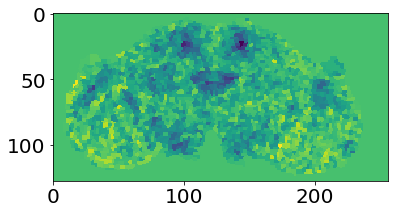

In [118]:
x_center = 5
y_center = 0
radius = 5
points = np.where((umap['fly_087'][:,0]-x_center)**2 + (umap['fly_087'][:,1]-y_center)**2 < radius**2)[0]
times = umap['fly_087'][points,6]

In [143]:
flies['fly_087'].cluster_signals.shape

(2000, 3384)

In [146]:
z

20

In [121]:
times[4000]

959.88

In [122]:
flies['fly_087'].timestamps.shape

(3384, 49)

In [123]:
flies['fly_087'].timestamps[:,20]

array([2.79079712e+02, 8.11075413e+02, 1.34307111e+03, ...,
       1.79895654e+06, 1.79948854e+06, 1.80002054e+06])

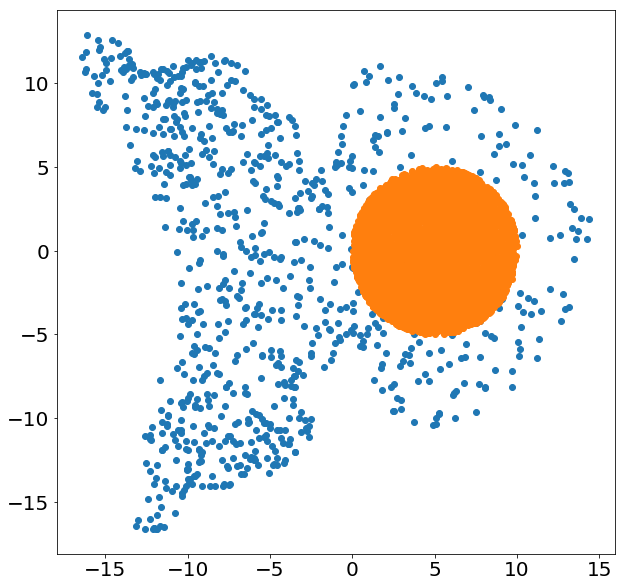

In [115]:
plt.figure(figsize=(10,10))
plt.plot(umap['fly_087'][::100,0],umap['fly_087'][::100,1],'o')
plt.plot(umap['fly_087'][points,0],umap['fly_087'][points,1],'o')

In [ ]:
np.where(umap['fly_087'][:,0])

In [104]:
len(np.unique(umap['fly_087'][:,5]))

2412

In [98]:
64*64

4096

In [16]:
umap_raw[:10,5]

array(['1750', '1613', '1522', '1434', '1317', '1256', '1204', '1176',
       '1178', '1178'], dtype='<U30')

In [57]:
### Grab fly94 ###

fly94_idx = np.where(umap_raw[:,-1]=='fictrac-20200620_122048_fly94')[0]
umap_fly94 = umap_raw[fly94_idx,:-1].astype(float)

In [58]:
umap_fly94[-10:,-1]

array([1799.52, 1799.54, 1799.56, 1799.58, 1799.6 , 1799.62, 1799.64,
       1799.66, 1799.68, 1799.7 ])

In [60]:
umap_fly94[:10,-1]

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18])

In [53]:
umap_fly94.shape

(89986, 3)

In [131]:
umap_x_all.shape

(9, 49, 3384)

In [11]:
#umap_x, umap_y = interp_umap(z=40)